In [1]:
import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Preprocessing

In [2]:
img_list = glob('dataset/*.png')
len(img_list)

1040

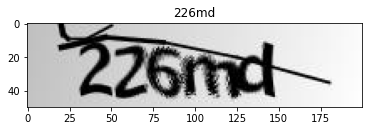

In [3]:
img = cv2.imread(img_list[0])
label = os.path.splitext(os.path.basename(img_list[0]))[0]

plt.title(label)
plt.imshow(img)

In [4]:
imgs = []
labels = []
max_length = 0

for i in img_list:
    imgs.append(i)
    
    label = os.path.splitext(os.path.basename(i))[0]
    labels.append(label)
    
    if len(label) > max_length:
        max_length = len(label)
        
print(len(imgs),len(labels),max_length)

1040 1040 5


In [5]:
''.join(labels)

'226md22d5n2356g23mdg23n88243mm244e2245y524f6w24pew25257253dc25egp25m6p25p2m25w53264m5268g22834828x472b8272bg482cegf2cg582cgyx2en7g2enf42fxgd2g7832g7nm2gyb62mg872mpnn2n73f2nbcx2nf262npg62nx382p2y82pfpn2w4y72wc382wx732x7bm2xc2n2ycn82yggg325fb32cnn32dnn33b2233f7m33n7333ng433p4e34b8434fxm34pcn368y536bc236nx436w25373gb377xx378e537d5237ep6387g238n573b4we3bd8f3bfnd3bnyf3bx863cpwb3d7bd3den63dgmf3ebnn3ebpw3eny73fbxd3g2w63mxdn3n2b43n3cf3n7mx3ndxd3nfdn3nnpw3nw7w3ny453p4nn3p67n3pe4g3w2bw3wnd33x3253x5fm3xcgg3xng63ye2e3ygde3ym7f428b642dw442nxy42xpy43gey43mn543p5d43xfe4433m445cc44c2244fyb44xe844ype467d546mbm4743p474ff478nx47e4p47m2b488de4b2pw4c8n84cfw84cn7b4d22m4dgf74dw3w4egem4exnn4f8yp4fc364fp5g4gb3f4gycb4m2w54n2yg4n3mn4nc374nnf34w6mw4w76g4yc854ycex4ynf3524475325m537nf53mn853wb853wp3556wd55w5c55y2m56c3456m6y56ncx573bn573d8574d757b2757gnx57wdp58b5m58pnp5bb665bg8f5bgp25bnd75dxnm5ep3n5expp5f3gf5fyem5g5e55gcd35mcy75mf7c5mfff5mgn45mnpd5n2455n3w45n7285n7325ng6e5nggg5nm6d5nnff5np4m5npdn5nxnn5p3mm5p8fm5pm6

In [6]:
characters = set(''.join(labels))
characters

{'2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y'}

In [7]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=1, mask_token=None, invert=True
)

print(labels[0])
encoded = char_to_num(tf.strings.unicode_split(labels[0], input_encoding='UTF-8'))
print(encoded)

226md
tf.Tensor([12 12 11 17  9], shape=(5,), dtype=int64)


In [8]:
tf.strings.reduce_join(num_to_char(encoded)).numpy().decode('utf-8')

'226md'

# Split Dataset

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(imgs,labels,test_size=0.1,random_state=2021)

print(len(x_train),len(y_train))
print(len(x_val),len(y_val))

936 936
104 104


# Create Data Generator

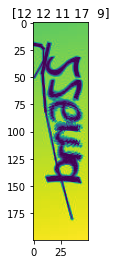

In [10]:
img_width = 200
img_height = 50

def encode_single_sample(img_path, label):
  # 1. Read image
  img = tf.io.read_file(img_path)
  # 2. Decode and convert to grayscale
  img = tf.io.decode_png(img, channels=1)
  # 3. Convert to float32 in [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4. Resize to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  # 5. Transpose the image because we want the time
  # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])
  # 6. Map the characters in label to numbers
  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  # 7. Return a dict as our model is expecting two inputs
  return {'image': img, 'label': label}

preview = encode_single_sample(imgs[0], labels[0])

plt.title(str(preview['label'].numpy()))
plt.imshow(preview['image'].numpy().squeeze())

In [11]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(validation_dataset)

<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>
<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>


# Model

In [12]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name='ctc_loss')(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
_________________________________________________________________________________

# Train

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
30/30 [==============================] - 16s 525ms/step - loss: 27.3076 - val_loss: 16.3067
Epoch 2/100
30/30 [==============================] - 10s 329ms/step - loss: 16.3528 - val_loss: 16.2977
Epoch 3/100
30/30 [==============================] - 10s 339ms/step - loss: 16.3198 - val_loss: 16.2625
Epoch 4/100
30/30 [==============================] - 12s 397ms/step - loss: 16.3173 - val_loss: 16.2649
Epoch 5/100
30/30 [==============================] - 12s 391ms/step - loss: 16.3168 - val_loss: 16.2664
Epoch 6/100
30/30 [==============================] - 11s 352ms/step - loss: 16.3161 - val_loss: 16.2643
Epoch 7/100
30/30 [==============================] - 9s 316ms/step - loss: 16.3149 - val_loss: 16.2648
Epoch 8/100
30/30 [==============================] - 10s 317ms/step - loss: 16.3135 - val_loss: 16.2622
Epoch 9/100
30/30 [==============================] - 10s 325ms/step - loss: 16.3116 - val_loss: 16.2627
Epoch 10/100
30/30 [==============================] - 10s 330ms/s

30/30 [==============================] - 11s 372ms/step - loss: 0.0166 - val_loss: 0.0042
Epoch 81/100
30/30 [==============================] - 11s 373ms/step - loss: 0.0170 - val_loss: 0.0023
Epoch 82/100
30/30 [==============================] - 11s 380ms/step - loss: 0.0107 - val_loss: 0.0022
Epoch 83/100
30/30 [==============================] - 11s 368ms/step - loss: 0.0150 - val_loss: 0.0036
Epoch 84/100
30/30 [==============================] - 13s 443ms/step - loss: 0.0170 - val_loss: 0.0028
Epoch 85/100
30/30 [==============================] - 11s 380ms/step - loss: 0.0413 - val_loss: 0.0025
Epoch 86/100
30/30 [==============================] - 11s 379ms/step - loss: 0.0171 - val_loss: 0.0021
Epoch 87/100
30/30 [==============================] - 11s 382ms/step - loss: 0.0221 - val_loss: 0.0025
Epoch 88/100
30/30 [==============================] - 12s 384ms/step - loss: 0.0188 - val_loss: 0.0023
Epoch 89/100
30/30 [==============================] - 12s 391ms/step - loss: 0.0194 - 

# Test Inference

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


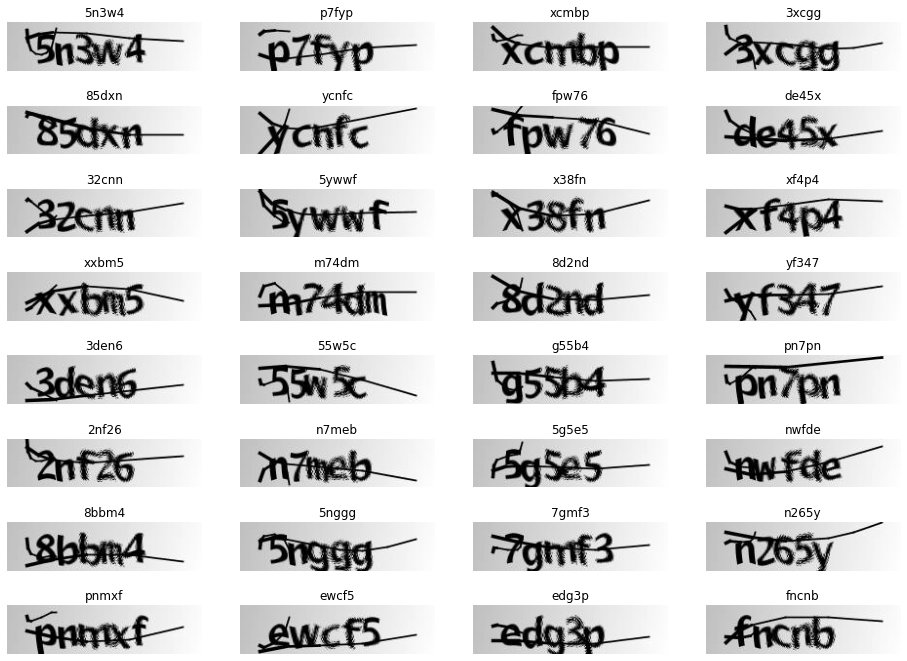

In [14]:
prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

for batch in validation_dataset.take(1):
    batch_images = batch['image']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(8, 4, figsize=(16, 12))

    for img, text, ax in zip(batch_images, pred_texts, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T

        ax.imshow(img, cmap='gray')
        ax.set_title(text)
        ax.set_axis_off()